# Spatial LDA Training and Inference

## Overview and Setup
This notebook allows users to train a spatial-LDA topic model using their preprocessed cell data.  The main topics covered are:

- [Loading Preprocessed Cell Data](#Loading-Preprocessed-Cell-Data)
- [Training and Inspecting the Model](#Training-and-Inspecting-the-Model)
- [Inferring Topic Weights on New Data](#Inferring-Topic-Weights-on-New-Data)
- [Visualizing and Saving Results](#Visualizing-and-Saving-Results)

#### Import Required Packages

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import spatial_lda.model
import spatial_lda.visualization

import ark.utils.spatial_lda_utils as spu
from ark.utils import example_dataset

## Loading Preprocessed Cell Data

In order to train a spatial-LDA model, the cell table must have been formatted and featurized using the steps in the `LDA_Preprocessing` notebook.  In addition, the required difference matrices should also have been generated through the use of the preprocessing notebook.

### Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change the `base_dir` to point to your own sub-directory within the data folder, rather than `'example_dataset'`.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [2]:
base_dir = "../data/example_dataset"

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended setting it to `True` if you have not run Notebooks 1-3, and LDA Preprocessing.

In [ ]:
example_dataset.get_example_dataset(dataset="LDA_training_inference", save_dir=base_dir, overwrite_existing=False)

#### Set Up File Paths
- `base_dir`: working directory
- `processed_dir`: directory containing the processed data produced from the `LDA_Preprocessing` notebook
- `cell_table_name`: name of the correctly formatted cell table file (`.pkl`)
- `difference_matrices_name`: name of the difference matrices file (`.pkl`)
- `features_name`: name of the featurized cell table file (`.pkl`)
- `viz_dir`: destination directory for all plots and visualizations

In [4]:
processed_dir = "spatial_analysis/spatial_lda/preprocessed"
cell_table_name = "formatted_cell_table"
difference_matrices_name = "difference_mats"
features_name = "featurized_cell_table"
viz_dir = os.path.join(base_dir, "spatial_analysis/spatial_lda/visualization")

processed_path = os.path.join(base_dir, processed_dir)

# Create directories if they do not exist
if not os.path.exists(viz_dir):
    os.makedirs(viz_dir)

#### Load in Data

In [5]:
cell_table = spu.read_spatial_lda_file(
    dir=processed_path, file_name=cell_table_name, format="pkl")

difference_matrices = spu.read_spatial_lda_file(
    dir=processed_path, file_name=difference_matrices_name, format="pkl")

featurized_cell_table = spu.read_spatial_lda_file(
    dir=processed_path, file_name=features_name, format="pkl")

## Training and Inspecting the Model

Model training takes place using a subset of the cell data to speed up the process.  To further save time, one can leverage parallel processing, if possible, by specifying the number of local CPUs to use.  For example, a new MacBook Pro or MacBook Air comes standard with 8 CPUs.  If using parallel processing, you should set the number of processes to be a divisor of the number of FOVs.

*Note: if using all available cores for model training, you should not have any other processes running at the same time.*

#### Setting Training Parameters
You can specify the number of parallel processes, topics, and the difference penalty below.  Larger values for the difference penalty mean adjacent cells are more likely to share topic preferences.

To see periodic progress updates, set `verbose=1`.  For more detailed output, set `verbose=2`.  Set `verbose=0` to silence all progress output.

In [6]:
# if you've already trained the model, set this to True to skip training
load_trained_model = False

num_processes = 4
num_topics = 11
difference_penalty = 250
verbose = 2

#logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)

#### Run Training Algorithm

In [ ]:
if not load_trained_model:
    trained_model = spatial_lda.model.train(
        sample_features=featurized_cell_table["train_features"],
        difference_matrices=difference_matrices["train_diff_mat"],
        n_parallel_processes=num_processes,
        n_topics=num_topics,
        difference_penalty=difference_penalty,
        verbosity=verbose
    )

In [8]:
if not load_trained_model:
    # Trained Model
    train_name = "trained_spatial_lda_model_num_topics={}_diff={}".format(
        num_topics, difference_penalty)

    spu.save_spatial_lda_file(
        data=trained_model,
        dir=os.path.join(base_dir, processed_dir),
        file_name=train_name,
        format="pkl")

In [9]:
if load_trained_model:
    # Trained Model
    train_name = "trained_spatial_lda_model_num_topics={}_diff={}".format(
        num_topics, difference_penalty)
    trained_model = spu.read_spatial_lda_file(
        dir=processed_path, file_name=train_name, format="pkl")

#### Visualize Topic Heatmap
The code below produces a heatmap of cell features against topic loadings and saves the output as a `png` file.

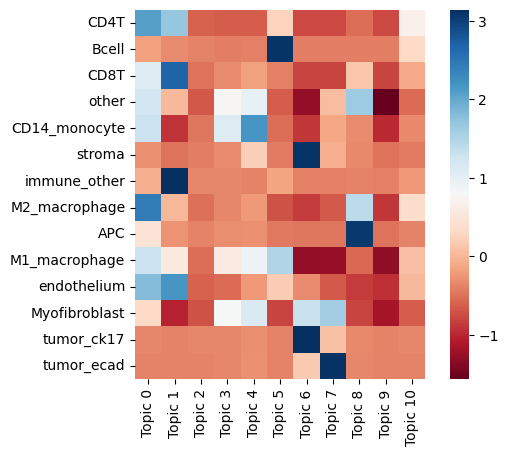

In [10]:
heatmap_path = os.path.join(
    viz_dir, "training_heatmap_features={}_num_topics={}.png".format(
        featurized_cell_table["featurization"], num_topics))

spatial_lda.visualization.plot_topics_heatmap(
    trained_model.components_, featurized_cell_table["train_features"].columns)
plt.savefig(heatmap_path)

#### Visualize Topic Assignments
Run the two code blocks below to visualize individual FOVs and the cell-level topic assignment.  The output will be saved to `viz_dir`.

In [11]:
# Subset training cells
fov_indices = featurized_cell_table["train_features"].index.map(lambda x: x[0])
cell_indices = featurized_cell_table["train_features"].index.map(lambda x: x[1])
training_cells = {}
for i in np.unique(fov_indices):
    training_cells[i] = cell_table[i].iloc[cell_indices[fov_indices == i],:]

Index(['Topic-0', 'Topic-1', 'Topic-2', 'Topic-3', 'Topic-4', 'Topic-5',
       'Topic-6', 'Topic-7', 'Topic-8', 'Topic-9', 'Topic-10'],
      dtype='object')


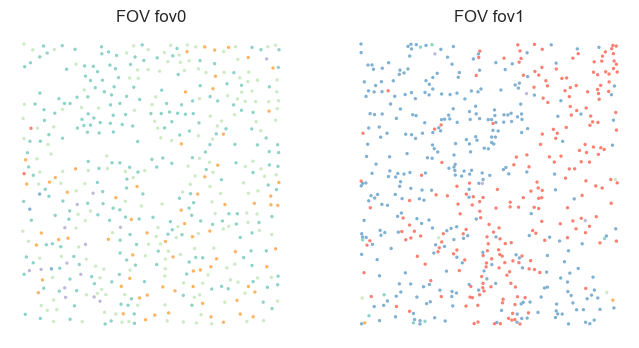

In [12]:
# Choose which FOVs to plot
fov_set = list(training_cells.keys())[0:2]
fov_labs = "_".join([str(x) for x in fov_set])

_plot_fn = spu.make_plot_fn(
    plot="topic_assignment", topic_weights=trained_model.topic_weights, cell_table=training_cells)

print(trained_model.topic_weights.columns)

plot_path = os.path.join(
    viz_dir,
    "training_topic_assignment_num_topics={}_fovs={}.png".format(num_topics, fov_labs))

# Generate Plot
spatial_lda.visualization.plot_samples_in_a_row(
    trained_model.topic_weights, _plot_fn, training_cells, fov_set)
plt.savefig(plot_path)

## Inferring Topic Weights on New Data
Based on the output from the trained model, you can choose to infer topic weights on the entire pooled data by running the code below.  You can change the number of parallel processes if you like, otherwise it will be the same as when running the training algorithm.

In [ ]:
complete_model = spatial_lda.model.infer(
    components=trained_model.components_,
    sample_features=featurized_cell_table["featurized_fovs"],
    difference_matrices=difference_matrices["inference_diff_mat"],
    difference_penalty=difference_penalty,
    n_parallel_processes=num_processes
)

## Visualizing and Saving Results

You can use the same heatmap and plotting functions as above to visualize the results of the full model.

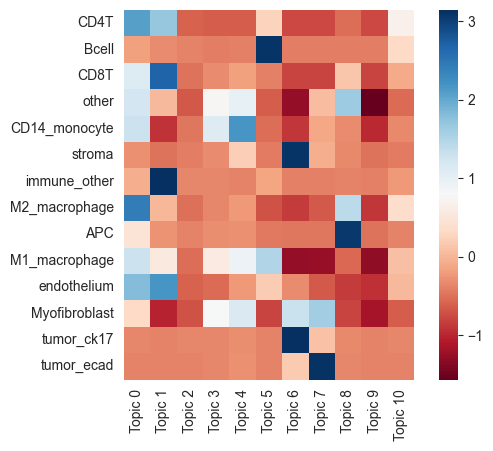

In [14]:
# Feature-Topic Heatmap
heatmap_path = os.path.join(
    viz_dir, "complete_heatmap_features={}_num_topics={}.png".format(
        featurized_cell_table["featurization"], num_topics))

spatial_lda.visualization.plot_topics_heatmap(
    complete_model.components_, featurized_cell_table["featurized_fovs"].columns)
plt.savefig(heatmap_path)

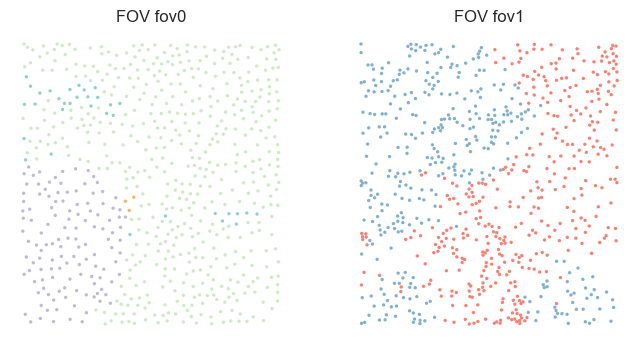

In [15]:
# Cell Topic Assignment
fov_set = list(training_cells.keys())[0:2]
fov_labs = "_".join([str(x) for x in fov_set])

_plot_fn = spu.make_plot_fn(
    plot="topic_assignment", topic_weights=complete_model.topic_weights, cell_table=cell_table)

plot_path = os.path.join(
    viz_dir,
    "complete_topic_assignment_num_topics={}_fovs={}.png".format(num_topics, fov_labs))

# Generate Plot
spatial_lda.visualization.plot_samples_in_a_row(
    complete_model.topic_weights, _plot_fn, cell_table, fov_set)
plt.savefig(plot_path)

#### Saving the Trained and Complete Models
Use the code below to save the trained and complete models for use on future data.

In [16]:
# Trained Model
train_name = "trained_spatial_lda_model_num_topics={}_diff={}".format(
    num_topics, difference_penalty)

spu.save_spatial_lda_file(
    data=trained_model,
    dir=os.path.join(base_dir, processed_dir),
    file_name=train_name,
    format="pkl")

In [17]:
# Complete Model
complete_name = "complete_spatial_lda_model_num_topics={}_diff={}".format(
    num_topics, difference_penalty)

spu.save_spatial_lda_file(
    data=complete_model,
    dir=os.path.join(base_dir, processed_dir),
    file_name=complete_name,
    format="pkl")